### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 7


### Дисциплина: Методы машинного обучения

##### Студент:  Яссин Мохамад Аламин
##### Группа:   НКНбд-01-20

## Москва 2023
***

# Вариант №24
Лабораторная работа 7

## Текст задания:

1. Набор данных: svhn_cropped 

2. Диапазон классов: 5–7 

3. Архитектура нейросети: MLP 

4. Показатель качества: cреднее абсолютное отклонение (MAE) для ошибки реконструкции 

 


## Решение:

In [ ]:
import random
random.seed(42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import cv2

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import tensorflow_datasets as tfds

### 1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки. Оставьте в обучающей и тестовой выборках диапазон классов, указанных в индивидуальном задании. Если изображения цветные (с тремя каналами), то перекодируйте их в одноцветные (оттенки серого).



In [ ]:
# Load dataset
(X_train, y_train), (X_test, y_test) = tfds.as_numpy(tfds.load("svhn_cropped", split=['train','test'],batch_size=-1,as_supervised=True))
print(f"Train dataset shape: {X_train.shape}")
print(f"Test dataset shape: {X_test.shape}")

Train dataset shape: (73257, 32, 32, 3)
Test dataset shape: (26032, 32, 32, 3)


In [ ]:
print(f"Shape of the first image in the train dataset: {X_train[0].shape}")

Shape of the first image in the train dataset: (32, 32, 3)


In [ ]:
# Filter labels with values from 5 to 7
filtered_indices_train = np.where(np.logical_and(y_train >= 5, y_train <= 7))
filtered_indices_test = np.where(np.logical_and(y_test >= 5, y_test <= 7))

X_train = X_train[filtered_indices_train]
y_train = y_train[filtered_indices_train]
X_test = X_test[filtered_indices_test]
y_test = y_test[filtered_indices_test]

# Convert colorful images to grayscale
X_train = np.asarray([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_train])
X_test = np.asarray([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in X_test])

# Normalize the grayscale images
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
print(f"Shape of the X_train size: {X_train[0].shape}")

Shape of the X_train size: (32, 32)


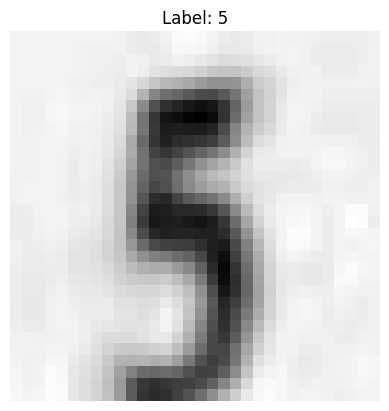

In [ ]:
# Print one example grayscale image
example_index = 2 # Change this index to visualize different examples
example_image = X_train[example_index]
example_label = y_train[example_index]

plt.imshow(example_image, cmap='gray')
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()

### 2. Создайте и обучите на обучающей выборке автокодировщик архитектуры, указанной в индивидуальном задании. Визуализируйте несколько исходных и восстановленных автокодировщиком изображений.


In [ ]:
import matplotlib.pyplot as plt

def image_show(orig_imgs, dec_imgs, fname=None):
    n = 5  # кол-во изображений
    fig = plt.figure(figsize=(26, 6))
    for i in range(n):
        # исходные изображения
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig_imgs[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # реконструированные изображения
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(dec_imgs[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

    if fname:
        fig.savefig(fname)    

In [ ]:
X_train = X_train.reshape(
    (len(X_train), np.prod(X_train.shape[1:])))
X_test  = X_test.reshape(
    (len(X_test), np.prod(X_test.shape[1:])))
X_train.shape, X_test.shape

((18204, 1024), (6380, 1024))

In [ ]:
def create_autoencoders (feature_layer_dim = 16):
    input_img = keras.layers.Input(shape = (1024,), name = 'Input_Layer')
    encoded = keras.layers.Dense(feature_layer_dim, activation = 'relu', 
                    name = 'Encoded_Features')(input_img)
    decoded = keras.layers.Dense(1024, activation = 'sigmoid', 
                    name = 'Decoded_Input')(encoded)

    autoencoder = keras.Model(input_img, decoded)
    encoder = keras.Model(input_img, encoded)

    encoded_input = keras.layers.Input(shape = (feature_layer_dim,))
    decoder = autoencoder.layers[-1]
    decoder = keras.Model(encoded_input, decoder(encoded_input))

    return autoencoder, encoder, decoder

In [ ]:
autoencoder, encoder, decoder = create_autoencoders(64)

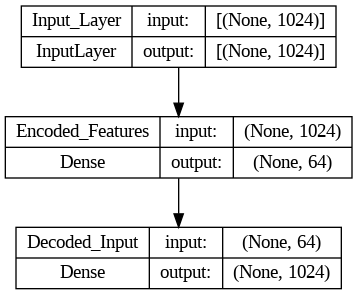

In [ ]:
keras.utils.plot_model(autoencoder, show_shapes=True)

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs=15,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose = 1);

Epoch 1/15
285/285 [==============================] - 3s 9ms/step - loss: 0.6745 - val_loss: 0.6445
Epoch 2/15
285/285 [==============================] - 2s 8ms/step - loss: 0.6509 - val_loss: 0.6228
Epoch 3/15
285/285 [==============================] - 2s 7ms/step - loss: 0.6313 - val_loss: 0.6060
Epoch 4/15
285/285 [==============================] - 2s 8ms/step - loss: 0.6231 - val_loss: 0.6005
Epoch 5/15
285/285 [==============================] - 3s 11ms/step - loss: 0.6213 - val_loss: 0.5992
Epoch 6/15
285/285 [==============================] - 2s 8ms/step - loss: 0.6205 - val_loss: 0.5984
Epoch 7/15
285/285 [==============================] - 2s 8ms/step - loss: 0.6200 - val_loss: 0.5980
Epoch 8/15
285/285 [==============================] - 2s 8ms/step - loss: 0.6198 - val_loss: 0.5979
Epoch 9/15
285/285 [==============================] - 2s 8ms/step - loss: 0.6197 - val_loss: 0.5977
Epoch 10/15
285/285 [==============================] - 3s 10ms/step - loss: 0.6195 - val_loss: 0.59

In [ ]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

200/200 [==============================] - 0s 2ms/step


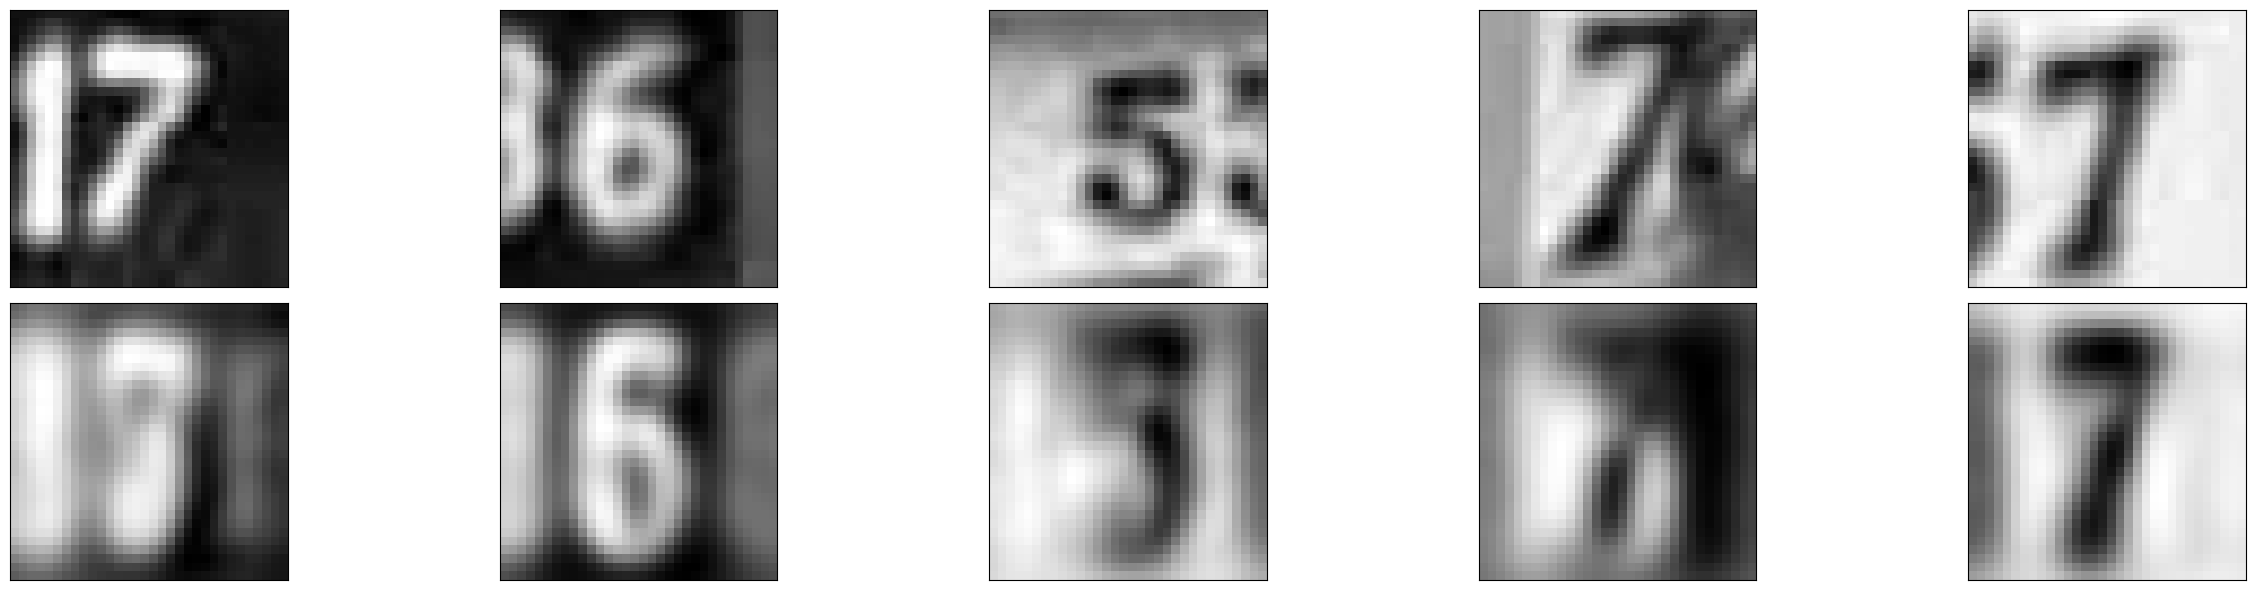

In [ ]:
image_show(X_test, decoded_imgs)

### 3. Оцените качество модели автокодировщика на тестовой выборке по показателю, указанному в индивидуальном задании.



In [ ]:
from sklearn.metrics import mean_absolute_error

# Predict on the test dataset
test_predictions = autoencoder.predict(X_test)

# Calculate the MAE
mae = mean_absolute_error(X_test, test_predictions)

print(f"MAE on test dataset: {mae}")

200/200 [==============================] - 0s 2ms/step
MAE on test dataset: 0.0625141924684474


### 4.Оставьте в наборах изображения первых двух классов диапазона, указанного в индивидуальном задании первыми. Визуализируйте набор данных на плоскости, соответствующей двум первым латентным признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

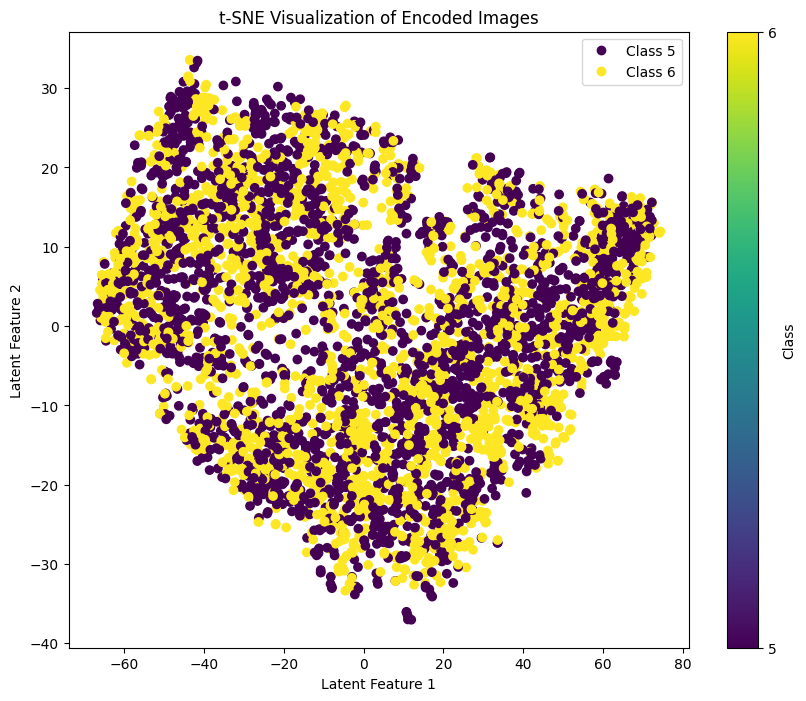

In [ ]:


# Keep only classes 5 and 6
filtered_indices_train = np.where(np.logical_or(y_train == 5, y_train == 6))
filtered_indices_test = np.where(np.logical_or(y_test == 5, y_test == 6))

X_train_filtered = X_train[filtered_indices_train]
y_train_filtered = y_train[filtered_indices_train]
X_test_filtered = X_test[filtered_indices_test]
y_test_filtered = y_test[filtered_indices_test]

# Convert grayscale images back to RGB for visualization
X_train_rgb = np.asarray([cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2BGR) for image in X_train_filtered])
X_test_rgb = np.asarray([cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2BGR) for image in X_test_filtered])

# Reshape the images for t-SNE
X_train_reshaped = X_train_filtered.reshape((len(X_train_filtered), -1))
X_test_reshaped = X_test_filtered.reshape((len(X_test_filtered), -1))

# Perform t-SNE on the encoded images ## Dimension reduction
tsne = TSNE(n_components=2, random_state=42)
encoded_tsne = tsne.fit_transform(X_test_reshaped)

# Plotting the data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(encoded_tsne[:, 0], encoded_tsne[:, 1], c=y_test_filtered, cmap='viridis')
plt.colorbar(scatter, ticks=[5, 6], label='Class')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.title('t-SNE Visualization of Encoded Images')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 5', 'Class 6'])
plt.show()


### 5. Выполните бинарную классификацию изображений по латентным (скрытым) признакам и всем признакам при помощи классификатора метода ближайших соседей (kNN). Оцените долю верных ответов (accuracy) для двух построенных классификаторов

In [ ]:
# Prepare the data
latent_features = encoder.predict(X_train)
all_features = X_train.reshape(X_train.shape[0], -1)

# Concatenate latent features with all features
combined_features = np.concatenate((latent_features, all_features), axis=1)

# Create binary labels for classes 5 and 6
binary_labels = (y_train >= 6).astype(int)

# Train the kNN classifier on latent features
knn_latent = KNeighborsClassifier(n_neighbors=5)
knn_latent.fit(latent_features, binary_labels)

# Train the kNN classifier on all features
knn_all = KNeighborsClassifier(n_neighbors=5)
knn_all.fit(all_features, binary_labels)

# Predict on the training and test data
train_preds_latent = knn_latent.predict(latent_features)
test_preds_latent = knn_latent.predict(encoder.predict(X_test).reshape(X_test.shape[0], -1))
train_preds_all = knn_all.predict(all_features)
test_preds_all = knn_all.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy
train_accuracy_latent = np.mean(train_preds_latent == binary_labels)
test_accuracy_latent = np.mean(test_preds_latent == (y_test >= 6).astype(int))
train_accuracy_all = np.mean(train_preds_all == binary_labels)
test_accuracy_all = np.mean(test_preds_all == (y_test >= 6).astype(int))

# Print the accuracies
print(f"Accuracy on latent features - Train: {train_accuracy_latent:.4f}, Test: {test_accuracy_latent:.4f}")
print(f"Accuracy on all features - Train: {train_accuracy_all:.4f}, Test: {test_accuracy_all:.4f}")

200/200 [==============================] - 0s 2ms/step
Accuracy on latent features - Train: 0.7963, Test: 0.6580
Accuracy on all features - Train: 0.8726, Test: 0.7801


### 6. Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) (Указание: используйте метод predict_proba() класса KNeighborsClassifier). 


200/200 [==============================] - 0s 2ms/step


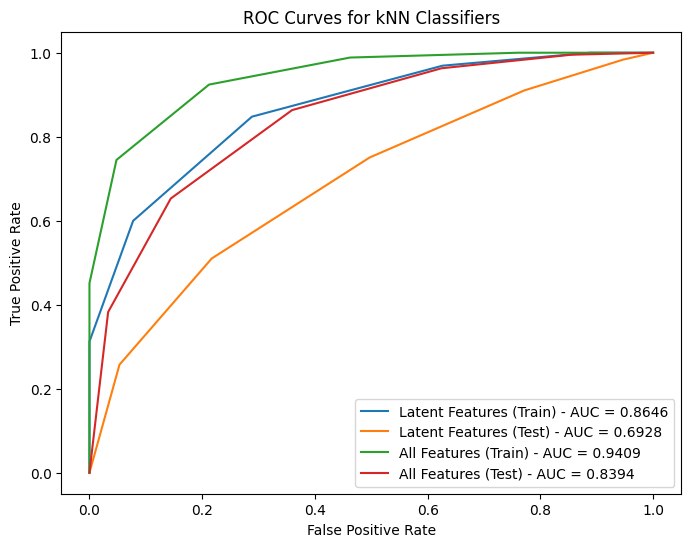

In [ ]:
# Calculate predicted probabilities for the kNN classifiers
train_prob_latent = knn_latent.predict_proba(latent_features)[:, 1]
test_prob_latent = knn_latent.predict_proba(encoder.predict(X_test).reshape(X_test.shape[0], -1))[:, 1]
train_prob_all = knn_all.predict_proba(all_features)[:, 1]
test_prob_all = knn_all.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1]

# Calculate the false positive rate and true positive rate for ROC curve
train_fpr_latent, train_tpr_latent, _ = roc_curve(binary_labels, train_prob_latent)
test_fpr_latent, test_tpr_latent, _ = roc_curve((y_test >= 6).astype(int), test_prob_latent)
train_fpr_all, train_tpr_all, _ = roc_curve(binary_labels, train_prob_all)
test_fpr_all, test_tpr_all, _ = roc_curve((y_test >= 6).astype(int), test_prob_all)

# Calculate AUC for ROC curve
train_auc_latent = auc(train_fpr_latent, train_tpr_latent)
test_auc_latent = auc(test_fpr_latent, test_tpr_latent)
train_auc_all = auc(train_fpr_all, train_tpr_all)
test_auc_all = auc(test_fpr_all, test_tpr_all)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(train_fpr_latent, train_tpr_latent, label=f"Latent Features (Train) - AUC = {train_auc_latent:.4f}")
plt.plot(test_fpr_latent, test_tpr_latent, label=f"Latent Features (Test) - AUC = {test_auc_latent:.4f}")
plt.plot(train_fpr_all, train_tpr_all, label=f"All Features (Train) - AUC = {train_auc_all:.4f}")
plt.plot(test_fpr_all, test_tpr_all, label=f"All Features (Test) - AUC = {test_auc_all:.4f}")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for kNN Classifiers')
plt.show()

### 7. Визуализируйте границы принятия решений классификатора kNN для латентных признаков на плоскости, соответствующей двум первым латентным признакам (для прочих латентных признаков задайте средние/медианные значения).




200/200 [==============================] - 1s 4ms/step


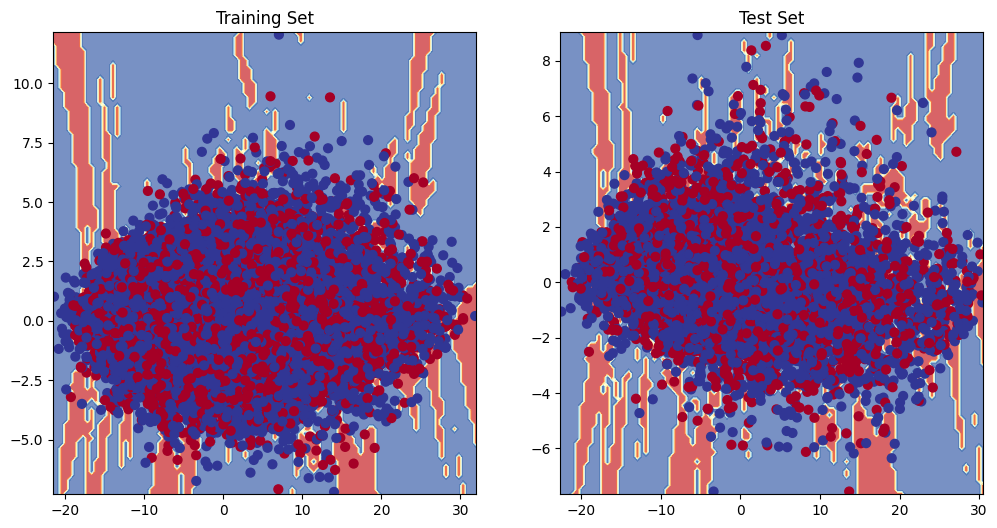

In [ ]:
#knn_latent.fit(latent_features, binary_labels)
def plot_decision_boundary(model, X, y):
    # Find the ranges for the axes and create a grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    # Flatten the grid to create input for prediction
    X_in = np.c_[xx.ravel(), yy.ravel()]
    # Predict using the trained model
    y_pred = model.predict(X_in)
    # Reshape the prediction for visualization
    y_pred = np.round(y_pred).reshape(xx.shape)
    # Plot the decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Perform PCA on the latent features
pca = PCA(n_components=2)
latent_features_pca = pca.fit_transform(latent_features)

# Create a new kNN classifier for the reduced features
knn_latent_pca = KNeighborsClassifier(n_neighbors=5)
knn_latent_pca.fit(latent_features_pca, binary_labels)
#knn_latent.fit(latent_features, binary_labels)

# Plot decision boundaries for the kNN classifier with reduced features
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training Set")
plot_decision_boundary(knn_latent_pca, X=latent_features_pca, y=binary_labels)
plt.subplot(1, 2, 2)
plt.title("Test Set")
latent_features_test = encoder.predict(X_test).reshape(X_test.shape[0], -1)
latent_features_test_pca = pca.transform(latent_features_test)
plot_decision_boundary(knn_latent_pca, X=latent_features_test_pca, y=(y_test >= 6).astype(int))
plt.show()

### 8. Определите на первоначальной тестовой выборке изображение, имеющее наибольшую ошибку реконструкции. Выведите для этого изображения первоначальное и реконструированное изображения.


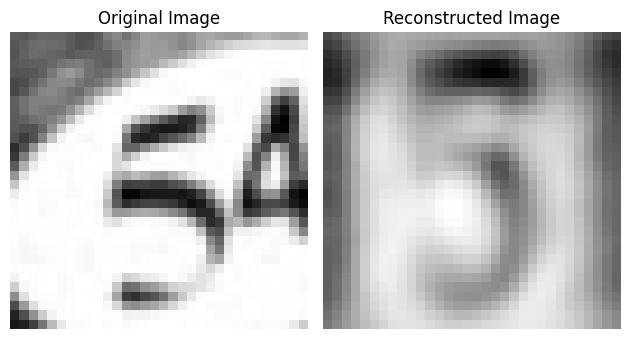

In [ ]:
# Calculate the reconstruction error for each image in the test set
reconstruction_errors = np.mean(np.square(X_test - decoded_imgs), axis=1)

# Find the index of the image with the maximum reconstruction error
max_error_index = np.argmax(reconstruction_errors)

# Retrieve the original and reconstructed images with the maximum error
original_image = X_test[max_error_index]
reconstructed_image = decoded_imgs[max_error_index]

# Reshape the images to the original shape
original_image = original_image.reshape((32, 32))
reconstructed_image = reconstructed_image.reshape((32, 32))

# Display the original and reconstructed images
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()